This is a short script used to create the plot in this tweet:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">I had a look at astro-ph gender ratio (according to the gender_guesser python library&#39;s classification of names, which is problematic to begin with) over time. Line is 7 day rolling mean, and dashed is mean for whole period. Feedback welcome, I probably missed something obvious! <a href="https://t.co/jWCjj6P7fy">pic.twitter.com/jWCjj6P7fy</a></p>&mdash; Ian Harrison (@itrharrison) <a href="https://twitter.com/itrharrison/status/1252645846040088578?ref_src=twsrc%5Etfw">April 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

I was a bit hesitant to share it publicly and I now probably regret it, as me spending 30 minutes mostly remembering how to use the arXiv API is in no way adequate for this kind of analysis, which has been done much better elsewhere. Deleting the tweet has its own problems, so I will at least provide the code and some of the caveats.

In [1]:
import urllib3
import feedparser
import gender_guesser.detector as gender

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=11)

A function which interrogates the [arXiv API](https://arxiv.org/help/api) for details of uploads. I originally wrote this code in 2012:

In [2]:
def get_arXiv_data(cat='astro-ph.CO', start=0, max_results=100, parse=True):
  '''Reads the results from an arXiv category, sorted by most recent first,
  from start to max_results.
  
  Returns
  -------
  d : the feedparser parsed data entries, or raw data, depending on
      the parse argument.
  '''

  http = urllib3.PoolManager()
  
  if max_results > 30000:
    raise Exception('Too many results requested! arXiv API recommends against > 30000')
  
  url = ('http://export.arxiv.org/api/query?search_query=cat:' + cat
         + '&sortBy=lastUpdatedDate&sortOrder=descending&start='
         + str(int(start)) + '&max_results=' + str(int(max_results)))
        
  data = http.request('GET', url).data
  if parse:
    d = feedparser.parse(data)
  else:
    d = data
  return d

Create a "gender detection" object, from the [gender-guesser](https://pypi.org/project/gender-guesser/) library. I am uncomfortable about using this as there are many potential pitfalls (such as mapping between people's names used in a professional context and their gender). The original data is described [here](https://autohotkey.com/board/topic/20260-gender-verification-by-forename-cmd-line-tool-db/).

It claims
> This list should be able to cover the vast majority of first names
in all European contries and in some overseas countries (e.g. China,
India, Japan, U.S.A.) as well.

But I have seen no quantification of this coverage. Given other widespread biases it seems very likely coverage is biased towards names with a European heritage.

In [3]:
gend = gender.Detector()

Fetch the arXiv data:

In [4]:
feed = get_arXiv_data(cat='astro-ph.*', start=0, max_results=10000)

Extract a few things, including listing dates and the full list of paper authors from the arXiv data.

In [5]:
arxiv_id = np.empty(len(feed.entries), dtype='S12')
pub_date = np.empty(len(feed.entries), dtype='datetime64[D]')
author_names = []
author_pubdate = []
author_gender = []

for i_p, paper in enumerate(feed.entries):
    arxiv_id[i_p] = paper.id.replace('http://arxiv.org/abs/', '')
    year = paper.updated_parsed.tm_year
    month = paper.updated_parsed.tm_mon
    day = paper.updated_parsed.tm_mday
    pub_date[i_p] = '{0}-{1:02d}-{2:02d}'.format(paper.updated_parsed.tm_year,
                                                 paper.updated_parsed.tm_mon,
                                                 paper.updated_parsed.tm_mday)
    
    for name in paper.authors:
        author_names.append(name['name'])
        author_pubdate.append(pub_date[i_p])
        author_gender.append(gend.get_gender(name['name'].split(' ')[0]))

In [15]:
author_pubdate = np.asarray(author_pubdate)
author_gender = np.asarray(author_gender)

dates = np.unique(author_pubdate)

n_male = np.zeros_like(dates, dtype=float)
n_female = np.zeros_like(dates, dtype=float)
n_unknown = np.zeros_like(dates, dtype=float)
n_andy = np.zeros_like(dates, dtype=float)

**For authors with names classed as `male` `mostly_male` `female` or `mostly_female`** find the fraction of `female` or `mostly_female` authors per day.

In [16]:
for i_date, date in enumerate(dates):
    n_male[i_date] = np.sum(author_gender[author_pubdate==date]=='male') + np.sum(author_gender[author_pubdate==dates]=='mostly_male')
    n_female[i_date] = np.sum(author_gender[author_pubdate==date]=='female') + np.sum(author_gender[author_pubdate==dates]=='mostly_female')
    n_unknown[i_date] = np.sum(author_gender[author_pubdate==date]=='unknown')
    n_andy[i_date] = np.sum(author_gender[author_pubdate==date]=='andy')

frac_fm = n_female/(n_male+n_female)

/Users/harrison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/harrison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Look at raw totals of these. Note the `gender-guesser` classifications `andy` for names that are often used for either binary gender, and `unknown` for names not in the database, which here mostly corresponds to where initial only is used in the arXiv listing.

In [21]:
print('guesser male: {0}, guesser female: {1}'.format(n_male.sum(), n_female.sum()))
print('guesser either: {0}, guesser not in database: {1}'.format(n_andy.sum(), n_unknown.sum()))

guesser male: 26302.0, guesser female: 7091.0
guesser either: 2429.0, guesser not in database: 66143.0


Take the seven-day rolling average for these quantities.

In [8]:
n_male_7day = np.convolve(n_male, np.ones((7,))/7, mode='valid')
n_female_7day = np.convolve(n_female, np.ones((7,))/7, mode='valid')
frac_fm_7day = np.convolve(frac_fm, np.ones((7,))/7, mode='valid')

Make a plot of the data.

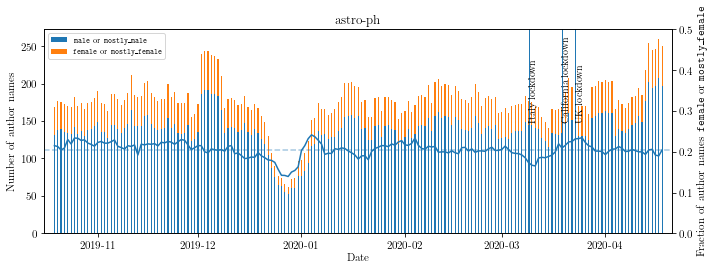

In [9]:
plt.close('all')
plt.figure(1, figsize=(2.5*4.5, 3.75))
plt.title('astro-ph')
plt.bar(dates[3:-3], n_male_7day, width=0.35, label='\\texttt{male} or \\texttt{mostly\_male}')
plt.bar(dates[3:-3], n_female_7day, width=0.35, bottom=n_male_7day, label='\\texttt{female} or \\texttt{mostly\_female}')
plt.legend(fontsize='x-small')
plt.axvline(np.datetime64('2020-03-23'),lw=1)
plt.text(np.datetime64('2020-03-23'), 150, 'UK lockdown', rotation=90, fontsize=10)
plt.axvline(np.datetime64('2020-03-09'), lw=1)
plt.text(np.datetime64('2020-03-09'), 150, 'Italy lockdown', rotation=90, fontsize=10)
plt.axvline(np.datetime64('2020-03-19'), lw=1)
plt.text(np.datetime64('2020-03-19'), 150, 'California lockdown', rotation=90, fontsize=10)
plt.xlabel('Date')
plt.ylabel('Number of author names')
plt.xlim(dates.min(), dates.max())
ax = plt.gca()
ax = plt.twinx()
#ax.plot(dates, frac_fm, '--', alpha=0.4)
ax.plot(dates[3:-3], frac_fm_7day, '-')
ax.axhline(frac_fm_7day.mean(), linestyle='dashed', alpha=0.4)
ax.set_ylim([0,0.5])
ax.set_ylabel('Fraction of author names \\texttt{female} or \\texttt{mostly\_female}')
plt.savefig('astro-ph_author_gender.png', dpi=300, bbox_inches='tight')
plt.show()